## Import the data
Here i load the data like in the example
we did not learn why we needed to normalize the data but i looked it up and its so the features get standardize and every feature contributes equaly, so i aplyed it direclty to the data so i only work with normilized data from here


In [20]:
import numpy as np
from sklearn import preprocessing

data = np.genfromtxt('dataset1.csv', delimiter=';', usecols=[1,2,3,4,5,6,7], converters={5: lambda s: 0 if s == b"-1" else float(s), 7: lambda s: 0 if s == b"-1" else float(s)})
dates = np.genfromtxt('dataset1.csv', delimiter=';', usecols=[0])
labels = []
for label in dates:
  if label < 20000301:
    labels.append('winter')
  elif 20000301 <= label < 20000601:
    labels.append('lente')
  elif 20000601 <= label < 20000901:
    labels.append('zomer')
  elif 20000901 <= label < 20001201:
    labels.append('herfst')
  else:
    labels.append('winter')
labels = np.array(labels)

normilized_data = preprocessing.normalize(data, axis=0)

## Implement the most basic K-Means algorithm
Here is my basic implementation of the K-Means algorythm, nothing special just like the reader

In [21]:
def euclidean_distance(a, b):
    """
    Calculates the squared Euclidean distance between two points.

    Parameters:
    - a (numpy array): A data point.
    - b (numpy array): Another data point.

    Returns:
    - float: The squared Euclidean distance between points `a` and `b`.
    """
    return np.sum((a - b) ** 2)


def KMeans(data: np.array, num_of_centroids: int, max_iters=60):
    """
    Performs K-Means clustering on the given data.

    Parameters:
    - data (numpy array): The dataset, shape (n_samples, n_features).
    - num_of_centroids (int): The number of clusters to form.
    - max_iters (int, optional): Maximum number of iterations to run the algorithm. Default is 60.

    Returns:
    - clusters (list of lists): A list of clusters, where each cluster contains the points assigned to it.
    - centroids (numpy array): The final centroids of the clusters, shape (num_of_centroids, n_features).
    """
    # Initialize centroids by randomly selecting `num_of_centroids` points from the data
    centroids = data[np.random.choice(data.shape[0], num_of_centroids, replace=False)]

    for _ in range(max_iters):
        # Create empty clusters for each centroid
        clusters = [[] for _ in range(num_of_centroids)]

        # Assign each point to the nearest centroid
        for point in data:
            # Calculate distances from the point to all centroids
            distances = [euclidean_distance(point, centroid) for centroid in centroids]
            # Find the index of the closest centroid
            closest_centroid = np.argmin(distances)
            # Assign the point to the corresponding cluster
            clusters[closest_centroid].append(point)

        # Calculate new centroids as the mean of the points in each cluster
        # If a cluster is empty, retain the current centroid
        new_centroids = np.array([np.mean(cluster, axis=0) if cluster else centroids[i] 
                                  for i, cluster in enumerate(clusters)])

        # Check if centroids have stabilized (no significant change)
        if np.allclose(new_centroids, centroids):
            centroids = new_centroids
            break

        # Update centroids for the next iteration
        centroids = new_centroids

    return clusters, centroids


# Example usage
num_of_clusters = 4
clusters, centroids = KMeans(normilized_data, num_of_clusters)


## Make some functions to test the results of the K-Means

To test the working of the algorythm i made a function that checs the with season is most precent in a cluster and asings it, then it also couts how many of the datapoint in that cluster are right acourding to the asinged season

Next to that i made a function with you can print all the clusters and the original seansos they had to see for yourself what the reslut is, it is not needed but i like to see it

In [22]:
import numpy as np

def assign_season_to_clusters_with_accuracy(clusters, original_data, labels):
    """
    Assigns the most common season to each cluster and calculates the accuracy of the assignment.

    Parameters:
    - clusters (list of lists): A list of clusters, where each cluster contains points (numpy arrays or lists).
    - original_data (numpy array): The original dataset, shape (n_samples, n_features).
    - labels (list or numpy array): The ground-truth labels (seasons) for each point in the original_data.

    Returns:
    - cluster_seasons (list): Most common season for each cluster.
    - cluster_accuracies (list): Accuracy percentage for each cluster.
    """
    cluster_seasons = []  # To store the most common season for each cluster
    cluster_accuracies = []  # To store the accuracy for each cluster

    for cluster in clusters:
        if cluster:  # Check if the cluster is not empty
            # Get indices of the cluster points in the original dataset
            original_index = [np.where((original_data == point).all(axis=1))[0][0] for point in cluster]
            
            # Get the season labels corresponding to the indices
            season_labels = [labels[point] for point in original_index]
            
            # Find the most common season in the cluster
            most_common_season = max(set(season_labels), key=season_labels.count)
            cluster_seasons.append(most_common_season)
            
            # Calculate accuracy as the percentage of points matching the most common season
            correct_count = season_labels.count(most_common_season)
            accuracy = (correct_count / len(season_labels)) * 100
            cluster_accuracies.append(accuracy)
        else:
            # For empty clusters, assign None for season and 0 for accuracy
            cluster_seasons.append(None)
            cluster_accuracies.append(0)
    
    return cluster_seasons, cluster_accuracies


def print_results(seasons, accuracies):
    """
    Prints the most likely season and accuracy for each cluster.

    Parameters:
    - seasons (list): The most common season assigned to each cluster.
    - accuracies (list): Accuracy percentages corresponding to each cluster.

    Returns:
    - None
    """
    for i, (season, accuracy) in enumerate(zip(seasons, accuracies)):
        print(f"Cluster {i+1} is most likely season: {season}, accuracy {accuracy:.2f}%")


cluster_seasons, cluster_accuracies = assign_season_to_clusters_with_accuracy(clusters, normilized_data, labels)
print_results(cluster_seasons, cluster_accuracies)



Cluster 1 is most likely season: winter, accuracy 48.94%
Cluster 2 is most likely season: zomer, accuracy 39.58%
Cluster 3 is most likely season: zomer, accuracy 54.84%
Cluster 4 is most likely season: winter, accuracy 41.51%


## Improve the K-Means
To try to make the K-Means peform better and dont rely on the change of badly chosen begining points \
for the centroids i made a funkction that runs the original KMeans function and keeps the reslults with the lowest intra_clusters \
 \
my outpyt abode is: \
Cluster 1 is most likely season: winter, accuracy 48.94% \
Cluster 2 is most likely season: zomer, accuracy 39.58% \
Cluster 3 is most likely season: zomer, accuracy 54.84% \
Cluster 4 is most likely season: winter, accuracy 41.51% \
 \
my outpyt below: \
Cluster 1 is most likely season: zomer, accuracy 56.57% \
Cluster 2 is most likely season: winter, accuracy 54.37% \
Cluster 3 is most likely season: herfst, accuracy 37.08% \
Cluster 4 is most likely season: herfst, accuracy 34.67% \
 \
what you see is that the acuracy of the 2 is both so bad there is not mych to say how much better the second is than the first seeing that the also change a lot every time i run \
i think this is also becouse of the number of clusters withc is realy low at the moment for both \
I wil test with what would be a good number below


In [ ]:

def calc_intra_clusters(clusters, centroids):
    """
    Calculate the sum of intra-cluster distances for a given set of clusters and their centroids.

    Parameters:
    - clusters (list of lists): A list where each element is a cluster (list of points).
    - centroids (list): A list of centroid points corresponding to each cluster.

    Returns:
    - intra_cluster_distances (list): A list of total distances for each cluster,
      where the distance is the sum of the Euclidean distances between each point
      in the cluster and its corresponding centroid.
    """
    intra_cluster_distances = []  # Store intra-cluster distances for each cluster

    # Loop through each cluster and its corresponding centroid
    for i, cluster in enumerate(clusters):
        # Calculate the total distance for the current cluster
        total_distance = sum(euclidean_distance(point, centroids[i]) for point in cluster)
        # Append the total distance to the results
        intra_cluster_distances.append(total_distance)

    return intra_cluster_distances


def better_KMeans(data, num_of_centroids, num_runs=10, max_iters=100):
    """
    Perform K-Means clustering multiple times to find the best clustering result
    with the lowest intra-cluster distance.

    Parameters:
    - data (list of points): The dataset to be clustered.
    - num_of_centroids (int): The number of centroids (clusters) to form.
    - num_runs (int, optional): The number of times to run the K-Means algorithm. Default is 10.
    - max_iters (int, optional): The maximum number of iterations for each K-Means run. Default is 100.

    Returns:
    - best_clusters (list of lists): The best clustering result (list of clusters) with the lowest intra-cluster distance.
    - best_centroids (list): The centroids corresponding to the best clustering result.
    - lowest_intra_cluster_distance (float): The total intra-cluster distance of the best result.
    """
    # Initialize variables to track the best clustering result
    best_clusters = None
    best_centroids = None
    lowest_intra_cluster_distance = float('inf')  # Start with an infinitely large distance

    # Perform K-Means multiple times
    for _ in range(num_runs):
        # Run K-Means algorithm
        clusters, centroids = KMeans(data, num_of_centroids, max_iters)

        # Calculate intra-cluster distances for the current result
        intra_cluster_distances = calc_intra_clusters(clusters, centroids)
        total_intra_cluster_distance = sum(intra_cluster_distances)

        # Update the best clustering result if the current run is better
        if total_intra_cluster_distance < lowest_intra_cluster_distance:
            lowest_intra_cluster_distance = total_intra_cluster_distance
            best_clusters = clusters
            best_centroids = centroids

    return best_clusters, best_centroids, lowest_intra_cluster_distance

num_of_clusters = 4
num_of_runs = 50
best_clusters, best_centroids, intra_cluster_distance = better_KMeans(normilized_data, num_of_clusters, num_of_runs)
cluster_seasons, cluster_accuracies = assign_season_to_clusters_with_accuracy(best_clusters, normilized_data, labels)
print_results(cluster_seasons, cluster_accuracies)


Cluster 1 is most likely season: zomer, accuracy 56.57%
Cluster 2 is most likely season: winter, accuracy 54.37%
Cluster 3 is most likely season: herfst, accuracy 37.08%
Cluster 4 is most likely season: herfst, accuracy 34.67%


## Plot the results

!! if the screen plot takes to long to compile i have a 2 screenshots in the folder with the results !!

As the number of clusters get more the intra-cluster distance lowers because smaller clusters make data points closer to their centroids. The biggest improvements happen early (e.g., going from 1 to 5 clusters), but after a certain point, adding more clusters gives not much more preformance. For example, moving from 10 to 11 clusters only reduces the distance slightly (0.59 → 0.55), and by 24 to 25 clusters, there's almost no change (0.35 → 0.35).

To pick the best number of clusters, you’d look for the "elbow point" on a plot of these values—probably around 6–10 clusters here. Too many clusters can lead to overfitting, so it’s best to balance compactness with simplicity. thats why i would say out of this is that the best amout of cluders would be 8 seeing that that is also a multiple of 4 seasons

What you can also see realy clearly is that the formar number of clusters i had chosen for a fast test (4) is actyaly way to small

Number of Clusters: 1, Intra-Cluster Distance: 2.66
Number of Clusters: 2, Intra-Cluster Distance: 1.72
Number of Clusters: 3, Intra-Cluster Distance: 1.25
Number of Clusters: 4, Intra-Cluster Distance: 1.08
Number of Clusters: 5, Intra-Cluster Distance: 0.94
Number of Clusters: 6, Intra-Cluster Distance: 0.83
Number of Clusters: 7, Intra-Cluster Distance: 0.74
Number of Clusters: 8, Intra-Cluster Distance: 0.69
Number of Clusters: 9, Intra-Cluster Distance: 0.64
Number of Clusters: 10, Intra-Cluster Distance: 0.60
Number of Clusters: 11, Intra-Cluster Distance: 0.56
Number of Clusters: 12, Intra-Cluster Distance: 0.53
Number of Clusters: 13, Intra-Cluster Distance: 0.51
Number of Clusters: 14, Intra-Cluster Distance: 0.49
Number of Clusters: 15, Intra-Cluster Distance: 0.46
Number of Clusters: 16, Intra-Cluster Distance: 0.44
Number of Clusters: 17, Intra-Cluster Distance: 0.42
Number of Clusters: 18, Intra-Cluster Distance: 0.41
Number of Clusters: 19, Intra-Cluster Distance: 0.40
Nu

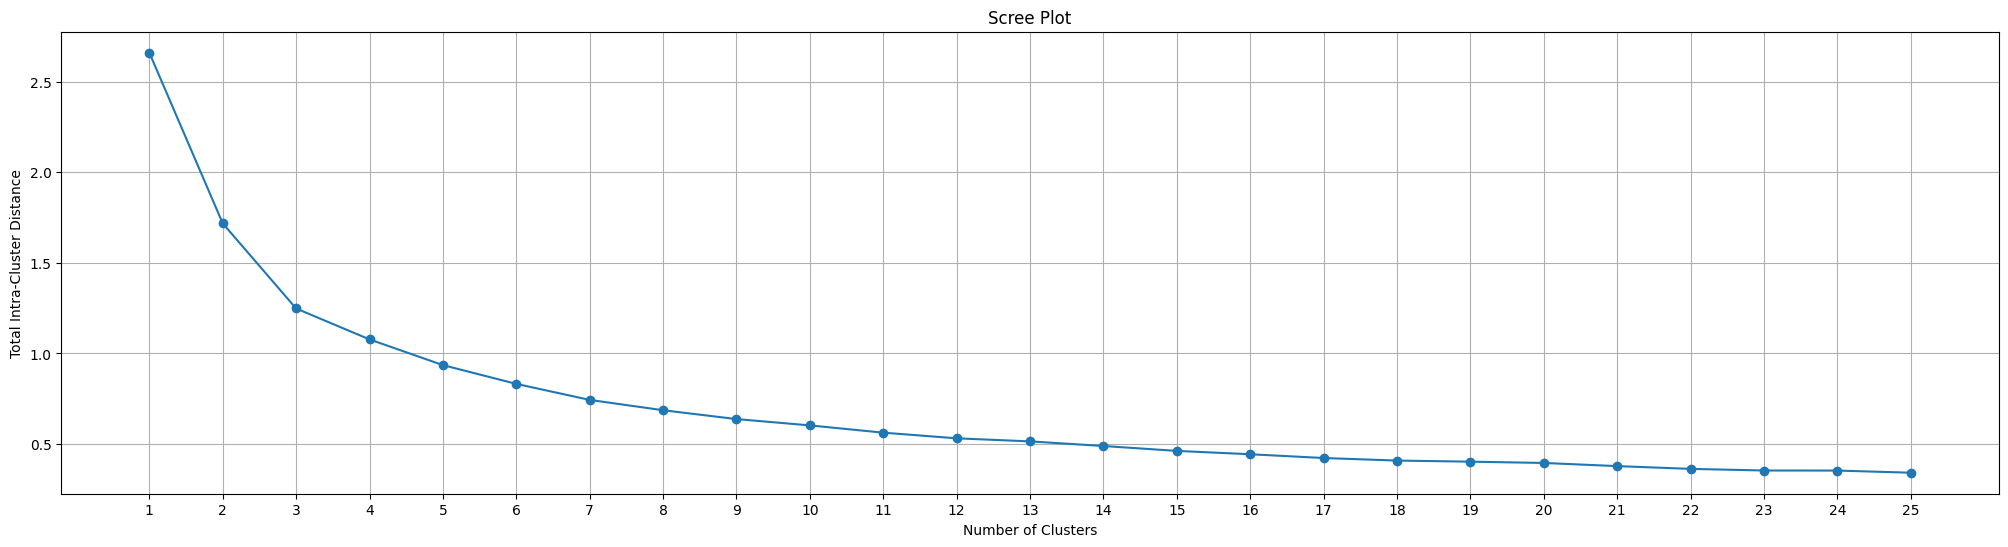

In [24]:
import matplotlib.pyplot as plt

def scree_plot(data, max_clusters=15, num_runs=10, max_iters=100):
    """
    Generate a Scree Plot to visualize the relationship between the number of clusters 
    and the total intra-cluster distance.

    Parameters:
    - data (list of points): The dataset to be clustered.
    - max_clusters (int, optional): The maximum number of clusters to evaluate. Default is 15.
    - num_runs (int, optional): The number of times to run the K-Means algorithm for each cluster count. Default is 10.
    - max_iters (int, optional): The maximum number of iterations for each K-Means run. Default is 100.

    Returns:
    - None: Directly displays a Scree Plot.
    """

    intra_cluster_distances = []

    for k in range(1, max_clusters + 1):
        _, _, total_distance = better_KMeans(data, k, num_runs=num_runs, max_iters=max_iters)
        intra_cluster_distances.append(total_distance)
        print(f"Number of Clusters: {k}, Intra-Cluster Distance: {total_distance:.2f}")

    plt.figure(figsize=(max_clusters, 6))
    plt.plot(range(1, max_clusters + 1), intra_cluster_distances, marker='o')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Total Intra-Cluster Distance")
    plt.title("Scree Plot")
    plt.xticks(range(1, max_clusters + 1))
    plt.grid(True)
    plt.show()

scree_plot(normilized_data, max_clusters=25, num_runs=25, max_iters=100)


In [25]:
num_of_clusters = 8
num_of_runs = 100
best_clusters, best_centroids, intra_cluster_distance = better_KMeans(normilized_data, num_of_clusters, num_of_runs)
cluster_seasons, cluster_accuracies = assign_season_to_clusters_with_accuracy(best_clusters, normilized_data, labels)
print_results(cluster_seasons, cluster_accuracies)

Cluster 1 is most likely season: winter, accuracy 48.44%
Cluster 2 is most likely season: herfst, accuracy 36.17%
Cluster 3 is most likely season: zomer, accuracy 52.63%
Cluster 4 is most likely season: zomer, accuracy 58.49%
Cluster 5 is most likely season: herfst, accuracy 50.00%
Cluster 6 is most likely season: zomer, accuracy 43.59%
Cluster 7 is most likely season: winter, accuracy 56.60%
Cluster 8 is most likely season: winter, accuracy 53.57%


Here i tryed the clustering again with the 8 clusters, its not great but definetly an improvement on before: \
\
Cluster 1 is most likely season: winter, accuracy 48.44% \
Cluster 2 is most likely season: herfst, accuracy 36.17% \
Cluster 3 is most likely season: zomer, accuracy 52.63% \
Cluster 4 is most likely season: zomer, accuracy 58.49% \
Cluster 5 is most likely season: herfst, accuracy 50.00% \
Cluster 6 is most likely season: zomer, accuracy 43.59% \
Cluster 7 is most likely season: winter, accuracy 56.60% \
Cluster 8 is most likely season: winter, accuracy 53.57% 